In [2]:
import pandas as pd
import string
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

#### 1. Parse Roscom

In [3]:
## find id
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]

urls = []

for page in tqdm(range(1, 200), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/199 [00:00<?, ?it/s]

In [5]:
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))
    soup = BeautifulSoup(res.text)

    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/995 [00:00<?, ?it/s]

In [10]:
import csv

questions_list = question

csv_file = 'save/questions.csv'

with open(csv_file, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    writer.writerow(['Question'])

    for question_text in questions_list:
            writer.writerow([question_text])

print(f'successfully {csv_file}')

NameError: name 'question' is not defined

In [11]:
csv_file = 'save/questions.csv'

data = pd.read_csv(csv_file, index_col='Question')
data.reset_index(inplace=True)
data.head(4)

,Question
0,Здравствуйте!\r\nХотела бы получить правовую к...
1,Добрый день. Прошу разобраться в отношении зак...
2,19 октября 2023 года я выписала товар в Wildbe...
3,"Здравствуйте,такая ситуация произошла,13-го чи..."


In [12]:
data.size

995

#### 2. Preprocessing

In [13]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from multiprocessing import Pool
from pymystem3 import Mystem
import pymorphy2

In [14]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grayni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [16]:
data['processed_question'] = list(tqdm(map(preprocess, data['Question']), total=len(data)))

  0%|          | 0/995 [00:00<?, ?it/s]

In [17]:
data.Question.iloc[4]

'Прошу принять меры в кафе по трассе с. Володино.\r\n18 октября 2023 года посетила кафе. Подавали еду в отбитых по краям осколками тарелках. Обратила внимание, что на других столах были такие же тарелки. '

In [18]:
' '.join(data.processed_question.iloc[4])

'просить принять мера кафе трасса володино октябрь год посетить кафе подавать еда отбить край осколок тарелка обратить внимание стол тарелка'

In [19]:
from gensim.models import *
from gensim import corpora

In [35]:
dictionary = corpora.Dictionary(data.processed_question)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None)
dictionary.save('save/lenta.dict')

In [36]:
corpus = [dictionary.doc2bow(text) for text in data.processed_question]
corpora.MmCorpus.serialize('save/lenta.model', corpus)

In [22]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: total: 797 ms
Wall time: 932 ms


In [23]:
print(lda)

LdaModel<num_terms=934, num_topics=20, decay=0.5, chunksize=50>


In [24]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(18,
  '0.132*"товар" + 0.059*"возврат" + 0.051*"деньга" + 0.036*"вернуть" + 0.034*"продавец" + 0.020*"пункт" + 0.018*"выдача" + 0.017*"это" + 0.016*"день" + 0.015*"заказ"'),
 (19,
  '0.261*"карта" + 0.217*"банк" + 0.138*"озон" + 0.046*"салон" + 0.045*"кредит" + 0.033*"рабочий" + 0.030*"деньга" + 0.026*"пройти" + 0.023*"услуга" + 0.021*"замена"'),
 (8,
  '0.195*"платить" + 0.125*"реквизит" + 0.122*"согласие" + 0.096*"россия" + 0.073*"автомобиль" + 0.065*"мама" + 0.056*"разбираться" + 0.033*"кредитный" + 0.018*"идти" + 0.003*"обратиться"'),
 (12,
  '0.086*"цена" + 0.083*"говорить" + 0.075*"вообще" + 0.056*"этаж" + 0.039*"жить" + 0.039*"проживать" + 0.039*"начать" + 0.036*"просто" + 0.035*"рубль" + 0.032*"это"'),
 (2,
  '0.172*"средство" + 0.122*"денежный" + 0.095*"сумма" + 0.072*"списать" + 0.050*"обращение" + 0.050*"требование" + 0.038*"рубль" + 0.038*"счёт" + 0.034*"требовать" + 0.026*"размер"'),
 (11,
  '0.074*"дом" + 0.044*"звонок" + 0.039*"подъезд" + 0.036*"просить" + 0.034*"отказ

In [25]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: total: 391 ms
Wall time: 2.74 s


In [26]:
print(lda.log_perplexity(corpus))

-9.635061953718115


In [28]:
print('Perplexy: ', np.exp(lda.log_perplexity(corpus)))

Perplexy:  6.540345545991669e-05


In [30]:
coherence_model_lda = CoherenceModel(model=lda, texts=data.processed_question, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Average coherence: ', coherence_lda)

Average coherence:  0.29781992744681807


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/5 [00:00<?, ?it/s]

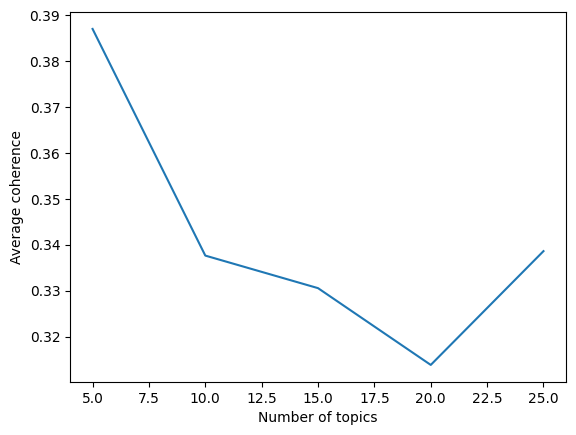

In [33]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data.processed_question, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Number of topics")
plt.ylabel("Average coherence")
plt.show()

In [34]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)